# AKT-inhibitor phosphoproteomics

## Setup

In [ ]:
# !pip install git+https://github.com/sky1ove/katlas.git -q

In [ ]:
!pip install statsmodels -q

In [ ]:
from katlas.core import *
import pandas as pd
from scipy.stats import ttest_rel
from tqdm import tqdm
import numpy as np 
from statsmodels.stats.multitest import multipletests
from katlas.core import *
from fastcore.basics import partial
from functools import reduce

In [ ]:
pd.set_option('display.precision', 15)

In [ ]:
def get_ttest(df, col1, col2, alpha=0.05, correction_method='fdr_bh',paired=False):
    """
    Performs t-tests and calculates log2 fold change between two groups in a DataFrame.
    NaN p-values are excluded from the multiple testing correction.

    Parameters:
    df (DataFrame): DataFrame with genes as index and patients as columns.
    col1, col2 (list): Column names for the two groups to compare.
    alpha (float): Significance level for multiple testing correction.
    correction_method (str): Method for multiple testing correction.

    Returns:
    DataFrame: Results including log2FC, p-values, adjusted p-values, and significance.
    """
    group1 = df[col1]
    group2 = df[col2]

    # Compute median values for each gene in both groups
    med1 = group1.median(axis=1)
    med2 = group2.median(axis=1)

    # Compute log2 fold change
    FCs = med2 - med1

    # Perform t-tests and handle NaN p-values
    if paired:
        t_results = [ttest_rel(group1.loc[gene], group2.loc[gene], nan_policy='omit') for gene in tqdm(df.index, desc="Computing t-tests")]
    else:
        t_results = [ttest_ind(group1.loc[gene], group2.loc[gene], nan_policy='omit') for gene in tqdm(df.index, desc="Computing t-tests")]

    
    p_values = [result.pvalue if result.pvalue is not np.nan else np.nan for result in t_results]

    # Exclude NaN p-values before multiple testing correction
    valid_p_values = np.array(p_values)
    valid_p_values = valid_p_values[~np.isnan(valid_p_values)]
    
    # Adjust for multiple testing on valid p-values only
    reject, pvals_corrected, _, _ = multipletests(valid_p_values, alpha=alpha, method=correction_method)
    
    # Create a full list of corrected p-values including NaNs for the excluded genes
    full_pvals_corrected = np.empty_like(p_values)
    full_pvals_corrected[:] = np.nan
    np.place(full_pvals_corrected, ~np.isnan(p_values), pvals_corrected)
    
    # Adjust the significance accordingly
    full_reject = np.zeros_like(p_values, dtype=bool)
    np.place(full_reject, ~np.isnan(p_values), reject)

    # Create DataFrame with results
    results = pd.DataFrame({
        'log2FC_median': FCs,
        'p_value': p_values,
        'p_adj': full_pvals_corrected,
        'significant': full_reject
    })

    results['p_value'] = results['p_value'].astype(float)
    
    return results

## Data

In [ ]:
df = pd.read_csv('raw/AKT_inhibitor.csv')

In [ ]:
df

,gene_site,site_seq,Control_R1,Control_R2,Control_R3,Control_R4,AZD5363_R1,AZD5363_R2,AZD5363_R3,AZD5363_R4,...,GSK690693_R3,GSK690693_R4,Ipatasertib_R1,Ipatasertib_R2,Ipatasertib_R3,Ipatasertib_R4,MK-2206_R1,MK-2206_R2,MK-2206_R3,MK-2206_R4
0,AAK1_S637,AGHRRILsDVtHsAV,14.167260000000001,13.791940000000000,13.888430000000000,13.991310000000000,14.581049999999999,14.802630000000001,14.723060000000000,14.857880000000000,...,14.47591,14.810269999999999,14.541550000000001,14.598560000000001,14.669480000000000,14.267690000000000,14.500560000000000,14.700110000000000,14.642170000000000,14.394790000000000
1,ABCF1_S105,MERLKKLsVPtsDEE,14.184260000000000,14.422390000000000,14.320520000000000,14.310689999999999,14.905970000000000,15.157950000000000,14.848050000000001,14.968950000000000,...,14.82788,14.924620000000001,14.888140000000000,15.019850000000000,14.857740000000000,14.809049999999999,14.915050000000001,14.815270000000000,15.067920000000001,14.526149999999999
2,ACIN1_S208,HSPRKSSsIsEEKGD,15.956730000000000,15.791060000000000,NaN,15.961280000000000,14.763690000000000,14.926340000000000,NaN,14.933990000000000,...,NaN,14.728800000000000,15.004510000000000,14.969420000000000,NaN,14.797020000000000,14.923180000000000,15.012650000000001,NaN,15.046220000000000
3,ACIN1_S216,IsEEKGDsDDEKPRK,17.457689999999999,16.997420000000002,17.373349999999999,17.434950000000001,16.252500000000001,16.341049999999999,16.316970000000001,16.411560000000001,...,16.38372,16.193570000000001,16.486070000000002,16.445869999999999,16.275169999999999,16.242329999999999,16.405529999999999,16.500750000000000,16.558160000000001,16.533030000000000
4,ACIN1_S240,QARAAkLsEGsQPAE,13.211040000000001,13.129730000000000,13.565530000000001,13.572440000000000,12.127129999999999,12.011320000000000,12.125540000000001,11.806080000000000,...,12.09775,12.322410000000000,11.838360000000000,12.090270000000000,12.027799999999999,11.561370000000000,12.093400000000001,12.152469999999999,12.159110000000000,11.888489999999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10895,ZYX_S308,ALsAGtGsPQPPsFt,11.331410000000000,11.552250000000001,11.535660000000000,NaN,11.861490000000000,11.590350000000001,11.684360000000000,NaN,...,11.48827,NaN,11.241320000000000,11.528520000000000,11.424130000000000,NaN,11.563599999999999,11.414809999999999,11.554449999999999,NaN
10896,ZYX_S344,QNQNQVrsPGAPGPL,16.165450000000000,16.694350000000000,16.624890000000001,16.640699999999999,16.674939999999999,16.860610000000001,16.820910000000001,16.760439999999999,...,16.58822,16.623080000000002,16.681480000000001,16.605000000000000,16.669180000000001,16.572299999999998,16.681220000000000,16.515260000000001,16.638909999999999,16.519490000000001
10897,ZZEF1_S2443,EEVERPVssPGDPEQ,14.662950000000000,14.461040000000001,14.543749999999999,NaN,14.356339999999999,14.548249999999999,14.445140000000000,NaN,...,14.50673,NaN,14.469010000000001,14.419820000000000,14.443940000000000,NaN,14.484690000000001,14.491320000000000,14.548760000000000,NaN
10898,ZZEF1_S2444,EVERPVssPGDPEQK,15.497130000000000,15.515750000000001,15.574990000000000,15.600479999999999,15.547800000000001,15.636749999999999,15.514320000000000,15.500999999999999,...,15.58136,15.607870000000000,15.518500000000000,15.604170000000000,15.527830000000000,15.421749999999999,15.555400000000001,15.553260000000000,15.601540000000000,15.483670000000000


## Get statistics

In [ ]:
ctrl = df.columns[df.columns.str.contains('Control')]

In [ ]:
df.columns

Index(['gene_site', 'site_seq', 'Control_R1', 'Control_R2', 'Control_R3',
       'Control_R4', 'AZD5363_R1', 'AZD5363_R2', 'AZD5363_R3', 'AZD5363_R4',
       'GSK2110183_R1', 'GSK2110183_R2', 'GSK2110183_R3', 'GSK2110183_R4',
       'GSK690693_R1', 'GSK690693_R2', 'GSK690693_R3', 'GSK690693_R4',
       'Ipatasertib_R1', 'Ipatasertib_R2', 'Ipatasertib_R3', 'Ipatasertib_R4',
       'MK-2206_R1', 'MK-2206_R2', 'MK-2206_R3', 'MK-2206_R4'],
      dtype='object')

In [ ]:
AZD = df.columns[df.columns.str.contains('AZD5363')]
GSK = df.columns[df.columns.str.contains('GSK2110183')]
ipa = df.columns[df.columns.str.contains('Ipatasertib')]
MK = df.columns[df.columns.str.contains('MK')]

In [ ]:
azd = get_ttest(df,ctrl, AZD,paired=True)

Computing t-tests: 100%|██████████| 10900/10900 [00:02<00:00, 3873.62it/s]
/tmp/ipykernel_5837/3198989361.py:35: UserWarning: Warning: converting a masked element to nan.
  valid_p_values = np.array(p_values)
<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/tmp/ipykernel_5837/3198989361.py:44: UserWarning: Warning: converting a masked element to nan.
  np.place(full_pvals_corrected, ~np.isnan(p_values), pvals_corrected)
/tmp/ipykernel_5837/3198989361.py:48: UserWarning: Warning: converting a masked element to nan.
  np.place(full_reject, ~np.isnan(p_values), reject)
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [ ]:
info = df.iloc[:,:2]

In [ ]:
azd = pd.concat([info,azd],axis=1)

In [ ]:
def convert_p(r,p_col,FC_col):
    log10 = -np.log10(r[p_col])
    return -log10 if r[FC_col]<0 else log10

In [ ]:
azd['logP'] = azd.apply(convert_p,axis=1,args=('p_value','log2FC_median'))

In [ ]:
def preprocess_seq(seq):
    # Convert non-sty to capital
    seq2 = ''.join([char.upper() if char not in ['s', 't', 'y'] else char for char in seq])
    
    # Convert rare amino acids to "_"
    allowed_chars = set('PGACSTVILMFYWHKRQNDEsty')  # Corrected to set of individual characters
    
    seq3 = ''.join(char if char in allowed_chars else '_' for char in seq2)
    
    return seq3

In [ ]:
azd=azd.dropna(subset='site_seq')

In [ ]:
azd['site_seq2'] = azd.site_seq.str.split(';')

azd = azd.explode('site_seq2').reset_index(drop=True)

In [ ]:
azd['site_seq3'] = azd['site_seq2'].apply(preprocess_seq)

In [ ]:
azd['len'] = azd.site_seq3.str.len()

In [ ]:
azd.sort_values('len')

,gene_site,site_seq,log2FC_median,p_value,p_adj,significant,logP,site_seq2,site_seq3,len
0,AAK1_S637,AGHRRILsDVtHsAV,0.822975000000001,0.008906484793829,0.140264264860036,False,2.050293669236857,AGHRRILsDVtHsAV,AGHRRILsDVtHsAV,15
7285,PIK3C2A_S259,kVSNLQVsPkSEDIS,0.208475000000000,0.038846230740454,0.232669123279732,False,1.410651114521674,kVSNLQVsPkSEDIS,KVSNLQVsPKSEDIS,15
7286,PIK3C2B_S155,EGSCKKLsPPPLPPR,0.088184999999999,0.190927344983904,0.434117714507528,False,0.719131866655360,EGSCKKLsPPPLPPR,EGSCKKLsPPPLPPR,15
7287,PIKFYVE_S1549,DAsPRNIsPGLQNGE,-0.034550000000001,0.664289112521403,0.792059381647510,False,-0.177642865442877,DAsPRNIsPGLQNGE,DAsPRNIsPGLQNGE,15
7288,PIKFYVE_S307,PARNRsAsItNLsLD,-0.158529999999999,0.798614583516688,0.880201512681016,False,-0.097662763409155,PARNRsAsItNLsLD,PARNRsAsItNLsLD,15
...,...,...,...,...,...,...,...,...,...,...
3648,DAB2IP_S978,ssssKGDsPELKPRA,0.052320000000002,0.986867769424062,0.992422713959899,False,0.005741034621776,ssssKGDsPELKPRA,ssssKGDsPELKPRA,15
3649,DAB2IP_S995,KQGPsPVsPNALDRT,0.102135000000001,0.103440867506425,0.336507037040304,False,0.985307845903440,KQGPsPVsPNALDRT,KQGPsPVsPNALDRT,15
3650,DAPK2_S349,EDLRNCEsDTEEDIA,0.063565000000001,0.324004421852016,0.547102601385693,False,0.489449062716765,EDLRNCEsDTEEDIA,EDLRNCEsDTEEDIA,15
3642,CXXC1_S224,KyFPssLsPVtPSES,0.079360000000001,0.221099567436877,0.461749263627937,False,0.655412107081897,KyFPssLsPVtPSES,KyFPssLsPVtPSES,15


## Get kinase score

In [ ]:
out = predict_kinase_df(azd,seq_col='site_seq3', **param_CDDM)

input dataframe has a length 10937
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:13<00:00, 21.13it/s]


In [ ]:
out

kinase,SRC,EPHA3,FES,NTRK3,ALK,EPHA8,ABL1,FLT3,EPHB2,FYN,...,MEK5,PKN2,MAP2K7,MRCKB,HIPK3,CDK8,BUB1,MEKK3,MAP2K3,GRK1
0,0.783249455337720,0.855073816467168,0.826277202880635,0.881706703749353,0.847476654874126,0.824322667449043,0.818788508709586,0.760742731932988,0.851728394943487,0.777402344625841,...,1.190651503001142,1.827369197593917,1.659866220735786,1.749661359547558,1.858462199312715,1.422013137966257,1.376607387140903,1.208567329370773,1.458284441988365,1.642000789419694
1,0.916136539008594,1.020824752169589,0.957129126684470,1.050054189371148,1.020052126926642,0.993500351083935,0.898746715686338,0.952178583795431,0.965072198713515,0.935283200837654,...,1.346701781244684,1.701378958120531,1.686051388225301,1.623036861501311,1.828286082474227,1.718263123290245,1.481258549931601,1.258051348661710,1.526841355860918,1.948495894181355
2,0.803615739537089,0.834078295915543,0.803571638960884,0.865171591762975,0.811906683249711,0.802747850657529,0.770055714940051,0.784014228411588,0.783880385469490,0.764095198171318,...,1.201608101868727,1.979780955623652,1.541251260816478,1.519855893845604,1.714454467353952,1.572442264567410,1.307797537619699,1.175688036013700,1.331678098127688,1.907740285513919
3,1.040906361236221,1.136256279595469,1.085247282247993,1.077164562121318,1.066256083995920,1.138728343742936,1.038576922911616,1.029348218461176,1.067611709347326,1.081160540171035,...,1.339168549974484,1.901378958120531,1.629418166374688,1.530557232489060,1.529102233676976,1.739684230918249,1.516689466484268,1.399490810135397,1.375454054996401,2.054708385317226
4,0.960574038284065,1.025193355415887,1.004664102477940,1.047470700497902,1.013664471072578,0.985893481637316,0.983882631975098,0.918895970803525,0.997810767671978,0.968626171860522,...,1.520452115379942,1.680785381908977,1.696076869989913,1.582796464323365,1.881013745704467,1.682369999882592,1.564842681258550,1.387288938496351,1.538207370164292,2.077128291840942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10932,0.671845940340767,0.665784956780683,0.648912432847029,0.775937034619398,0.673423330119305,0.621259862228196,0.792914213512048,0.746003683299664,0.675163176629123,0.645299621697736,...,1.234122500060752,1.615509022812394,2.057267611615438,1.162915341388621,2.272444158075601,1.796360055416622,1.386867305061560,1.335369105032551,1.701022719800763,1.465947845503255
10933,0.778758768962511,0.743598628102675,0.785156226657448,0.809792962986752,0.749689925749109,0.747812947200475,0.818624825355140,0.768542397716357,0.764902850623599,0.762359225020864,...,1.237017326431921,1.401884008625581,1.828783776609864,1.239999219099622,2.003436426116838,1.673301691850704,1.422435020519836,1.283702096765830,1.427664895253134,1.397732150609009
10934,0.993501314570144,0.947344328420935,0.962985238946246,0.985367398675441,0.963873784762090,0.933446502008600,1.041234608858008,0.982885347517534,0.951085238277029,1.062280025822217,...,1.223153750820150,1.812745431846555,1.825564049477093,1.633774241700681,2.024484536082475,1.876071348901647,1.621067031463748,1.352271311110398,1.516673083260094,1.895087117624713
10935,0.905936961931788,0.902399014301247,0.896029300690503,0.955552401251174,0.894863606747782,0.857809212872403,0.906811186630951,0.910521063118957,0.895820810388432,0.875000795897742,...,1.430858302349882,1.646702984905232,2.036133673090195,1.511612889661780,2.156679553264605,2.012666866260435,1.550478796169631,1.304659260118976,1.630077643032173,1.789814772381583


## Get report

In [ ]:
azd.site_seq.str[7].value_counts()

s    9757
t    1097
y      70
S       7
T       4
Y       2
Name: site_seq, dtype: int64

In [ ]:
azd['acceptor'] = azd.site_seq.str[7]

### Gene analysis

In [ ]:
azd['gene'] = azd.gene_site.str.split('_').str[0]

In [ ]:
def get_max(x):
    x = x.dropna().sort_values().values
    return x[0] if abs(x[0])>abs(x[-1]) else x[-1]

In [ ]:
azd_gene = azd.groupby('gene').\
agg({'logP':get_max,'gene_site':'count'}).reset_index().sort_values('logP',ascending=False)

In [ ]:
azd_gene['gene'] = azd_gene['gene'].str.split(';')

In [ ]:
azd_gene = azd_gene.explode('gene')

In [ ]:
azd_gene.sort_values('logP')

,gene,logP,gene_site
75,AKT1S1,-5.261993085200011,16
617,CXorf23,-5.119545591858334,2
2956,ZC3H13,-4.848553306466952,37
1887,PLEKHF2,-4.845626019000024,2
2947,ZBTB21,-4.826680128315477,14
...,...,...,...
1627,NEDD4L,4.195353987943070,13
222,BAHD1,4.325462890351067,4
1534,MRGBP,4.358231109938034,5
2055,PXN,4.583294485164098,19


In [ ]:
# azd_gene.query('logP>1.3 or logP<-1.3').to_csv('AKT_pthway.csv')

### Kinase analysis

In [ ]:
info = Data.get_kinase_info().rename(columns={'ID_HGNC':'gene'}).query('pseudo=="0"')

In [ ]:
azd_kinase = azd_gene.merge(info)

In [ ]:
azd_kinase.sort_values('logP')

,gene,logP,gene_site,kinase,ID_coral,uniprot,group,family,subfamily_coral,subfamily,...,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
164,RPS6KB1,-4.189142168890185,4,P70S6K,p70S6K,P23443,AGC,RSK,RSKp70,RSKp70,...,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
163,SRPK2,-2.853706040909945,8,SRPK2,SRPK2,P78362,CMGC,SRPK,None,SRPK,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
162,ULK1,-2.780005814723849,9,ULK1,ULK1,O75385,Other,ULK,None,ULK,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,cytosol
99,GSK3B,-2.743578046576185,2,GSK3B,GSK3B,P49841,CMGC,GSK,None,GSK,...,9.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
161,CHEK1,-2.678193238143057,2,CHK1,CHK1,O14757,CAMK,CAMKL,CHK1,CHK1,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,PBK,2.832017157780276,3,PBK,PBK,Q96KB5,Other,TOPK,None,TOPK,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nucleus
3,MAP3K7,2.837546087944340,7,TAK1,TAK1,O43318,TKL,MLK,TAK1,TAK1,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,cytosol
2,TESK2,2.917167554688220,4,TESK2,TESK2,Q96S53,TKL,LISK,TESK,TESK,...,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,nucleus
1,TNK1,3.043692153070804,5,TNK1,TNK1,Q13470,TK,Ack,None,Ack,...,6.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,cytosol


### Predicted kinase analysis

In [ ]:
def top_kinases(site_row,top_n=5):
    # Sort the row in descending order and get the top 5 kinases
    top_kinases = site_row.sort_values(ascending=False).head(top_n)
    
    # Get the counts of the top kinases
    kinase_counts = top_kinases.index.value_counts()
    
    return kinase_counts

def get_result(site,site_score,is_Y=True,top_n = 5):
    
    if is_Y:
        idx_up = site.index[(site.acceptor.str.upper()=="Y") & (site['logP']>1.3)]
        idx_dn = site.index[(site.acceptor.str.upper()=="Y") & (site['logP']<-1.3)]
    else:
        idx_up = site.index[(site.acceptor.str.upper()!="Y") & (site['logP']>1.3)]
        idx_dn = site.index[(site.acceptor.str.upper()!="Y") & (site['logP']<-1.3)]
    
    up_site = site.loc[idx_up]
    dn_site = site.loc[idx_dn]

    up_score = site_score.loc[idx_up]
    dn_score = site_score.loc[idx_dn]
    
    func = partial(top_kinases,top_n=top_n)
    
    up_cnt = up_score.apply(func,axis=1)
    dn_cnt = dn_score.apply(func,axis=1)
    
    df_up_cnt = up_cnt.sum().reset_index(name = 'up_cnt')
    df_dn_cnt = dn_cnt.sum().reset_index(name = 'dn_cnt')
    
    df_w_up = up_cnt.multiply(abs(up_site['logP']),axis=0).sum().reset_index(name = 'up_weighted_cnt')
    df_w_dn = dn_cnt.multiply(abs(dn_site['logP']),axis=0).sum().reset_index(name = 'dn_weighted_cnt')
    
    dfs = [df_up_cnt,df_dn_cnt,df_w_up,df_w_dn]
    
    result = reduce(lambda left, right: pd.merge(left, right, how='outer'), dfs)
    
    result = result.fillna(0)
    result['enrich'] = result.apply(lambda r: r.up_weighted_cnt if r.up_weighted_cnt >= r.dn_weighted_cnt else -r.dn_weighted_cnt,axis=1)
    result['change'] = result.up_weighted_cnt - result.dn_weighted_cnt
    
    
    return result

In [ ]:
st = get_result(azd,out,is_Y=False,top_n=10)

In [ ]:
st.sort_values('enrich')

,index,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change
125,P90RSK,222.0,232.0,416.077070306100097,544.037800344042125,-544.037800344042125,-127.960730037942028
1,AKT1,152.0,210.0,283.376314646904120,496.070095713943317,-496.070095713943317,-212.693781067039197
3,AKT3,107.0,171.0,202.466524789801326,423.694008987551058,-423.694008987551058,-221.227484197749732
162,RSK2,172.0,177.0,328.146960474807543,419.460511016354701,-419.460511016354701,-91.313550541547158
165,SGK1,95.0,165.0,176.687477557795802,394.309627787610054,-394.309627787610054,-217.622150229814252
...,...,...,...,...,...,...,...
27,CDK2,717.0,136.0,1358.587267632922249,281.945431543218035,1358.587267632922249,1076.641836089704157
53,ERK1,774.0,130.0,1464.208547620052286,274.655380550567600,1464.208547620052286,1189.553167069484743
26,CDK1,775.0,148.0,1465.161947796765844,312.929925490408891,1465.161947796765844,1152.232022306357067
29,CDK4,806.0,152.0,1529.687515461126623,321.232875181114480,1529.687515461126623,1208.454640280012200


In [ ]:
data = st.sort_values('change')[['index','change']]

In [ ]:
data.columns = ['Kinase','Score']

In [ ]:
d = pd.concat([data.head(),data.tail()]).set_index('Kinase')

In [ ]:
d

,Score
Kinase,
AKT2,-246.000744166140521
AKT3,-221.227484197749732
SGK1,-217.622150229814252
AKT1,-212.693781067039197
SGK2,-191.870111277172413
CDK2,1076.641836089704157
CDK1,1152.232022306357067
ERK1,1189.553167069484743
CDK4,1208.454640280012200


<AxesSubplot:ylabel='Kinase'>

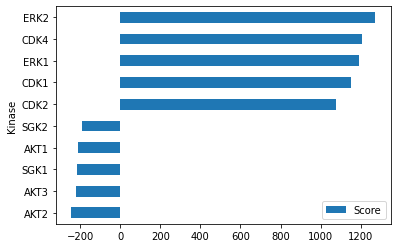

In [ ]:
d.plot.barh()

In [ ]:
# st.to_csv('AKT_kinase.csv',index=False)

In [ ]:
azd.acceptor.value_counts()

s    9757
t    1097
y      70
S       7
T       4
Y       2
Name: acceptor, dtype: int64

In [ ]:
y = get_result(azd,out)

In [ ]:
y.sort_values('enrich')

,index,up_cnt,dn_cnt,up_weighted_cnt,dn_weighted_cnt,enrich,change
25,EGFR,0.0,3.0,0.000000000000000,4.121320254189983,-4.121320254189983,-4.121320254189983
30,TNK1,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
28,FES,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
27,FER,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
29,SRC,0.0,1.0,0.000000000000000,1.616308532949250,-1.616308532949250,-1.616308532949250
26,EPHA8,0.0,1.0,0.000000000000000,1.367323280906877,-1.367323280906877,-1.367323280906877
9,FGFR4,1.0,0.0,1.561695987357824,0.000000000000000,1.561695987357824,1.561695987357824
14,KIT,1.0,1.0,1.561695987357824,1.367323280906877,1.561695987357824,0.194372706450948
1,BLK,1.0,0.0,1.571832444785475,0.000000000000000,1.571832444785475,1.571832444785475
4,EPHA2,1.0,1.0,1.571832444785475,1.367323280906877,1.571832444785475,0.204509163878599
